In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
        

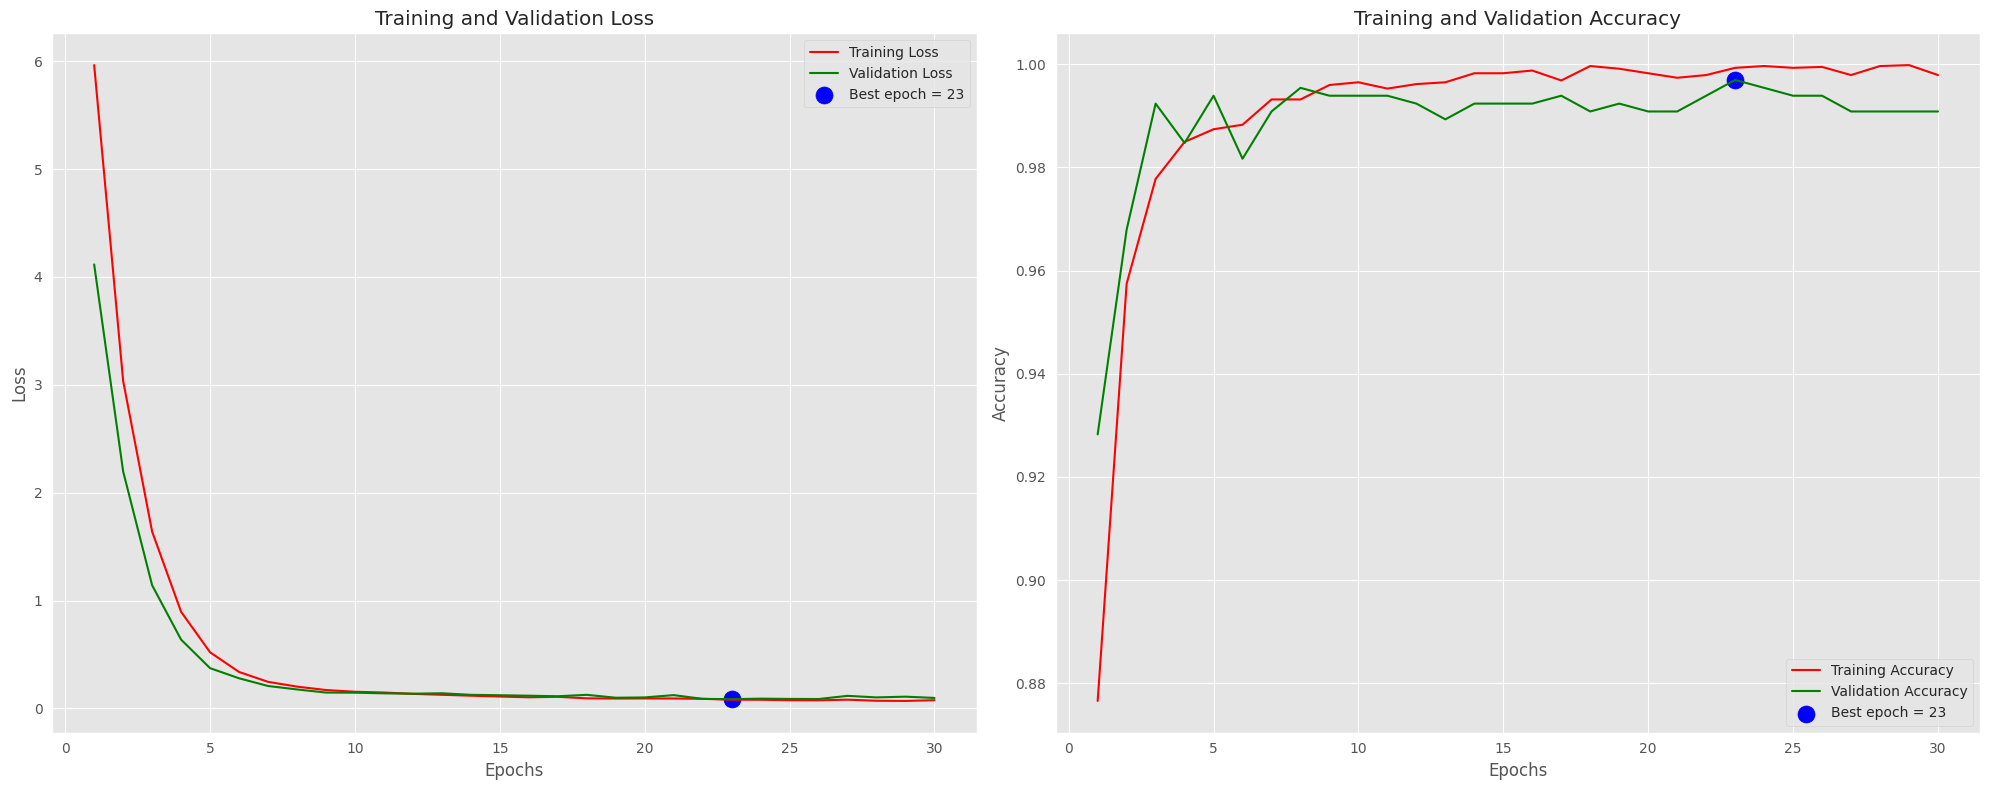

16/16 [==============================] - 1s 81ms/step - loss: 0.0922 - accuracy: 0.9911
Train Loss:  0.06202317401766777
Train Accuracy:  1.0
--------------------
Validation Loss:  0.09187661856412888
Validation Accuracy:  0.9910714030265808
--------------------
Test Loss:  0.09218913316726685
Test Accuracy:  0.9910714030265808
32/32 [==============================] - 5s 76ms/step


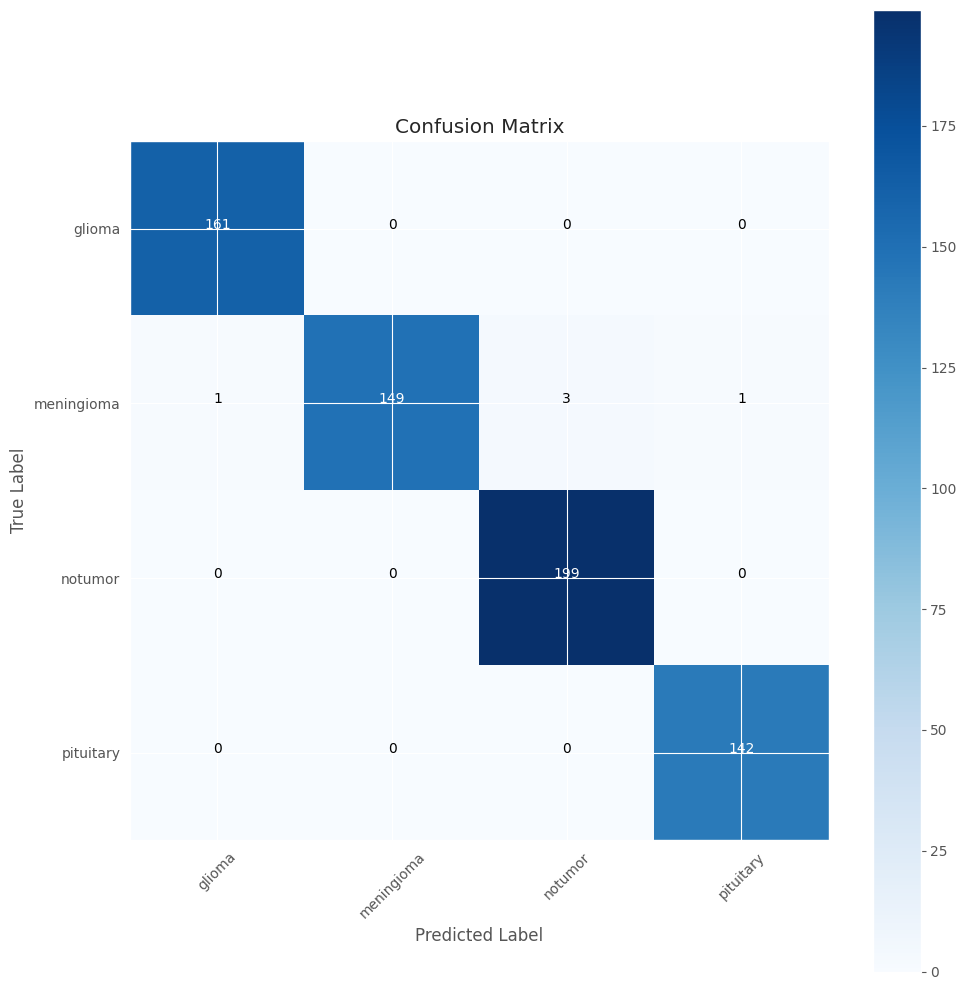

              precision    recall  f1-score   support

      glioma       0.99      1.00      1.00       161
  meningioma       1.00      0.97      0.98       154
     notumor       0.99      1.00      0.99       199
   pituitary       0.99      1.00      1.00       142

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [3]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

train_data_path = '/content/Training'
filepaths = []
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis=1)

test_data_path = '/content/Testing'
filepaths = []
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
test_df = pd.concat([Fseries, Lseries], axis=1)

valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (224, 224)
batch_size = 21

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback()])

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(20, 8))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [4]:
# Assuming the teacher model has already been trained and saved
teacher_model_path = 'teacher_model.h5'
model.save(teacher_model_path)  # Save the teacher model
teacher_model = tf.keras.models.load_model(teacher_model_path)

In [5]:
from tensorflow.keras.models import load_model

# Load the trained model
teacher_model = load_model('teacher_model.h5')

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adamax

# Create student model structure
student_model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape= img_shape),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation=LeakyReLU(alpha=0.1)),
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dense(num_class, activation='softmax')
])

student_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

student_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [7]:
import tensorflow.keras.backend as K

def distillation_loss(y_true, y_pred, teacher_logits, temperature=3, alpha=0.1):
    # Compute the distillation loss
    y_true = K.cast(y_true, 'float32')
    teacher_logits = K.cast(teacher_logits, 'float32')

    hard_loss = K.categorical_crossentropy(y_true, y_pred)
    soft_loss = K.categorical_crossentropy(
        K.softmax(teacher_logits / temperature),
        K.softmax(y_pred / temperature)
    )

    return alpha * hard_loss + (1 - alpha) * soft_loss

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Define and compile the student model
student_model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation=LeakyReLU(alpha=0.1)),
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dense(num_class, activation='softmax')
])

student_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

student_model.summary()

# Custom training loop for distillation
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature=3, alpha=0.1):
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, student_loss_fn):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn

    def train_step(self, data):
        x, y = data

        # Forward pass for teacher
        teacher_logits = self.teacher(x, training=False)

        # Forward pass for student
        with tf.GradientTape() as tape:
            student_logits = self.student(x, training=True)
            loss = distillation_loss(y, student_logits, teacher_logits, self.temperature, self.alpha)

        # Backward pass and optimize
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_logits)
        return {'loss': loss, **{m.name: m.result() for m in self.metrics}}

    def test_step(self, data):
        x, y = data

        # Forward pass for student
        student_logits = self.student(x, training=False)
        loss = self.student_loss_fn(y, student_logits)

        self.compiled_metrics.update_state(y, student_logits)
        return {'loss': loss, **{m.name: m.result() for m in self.metrics}}

# Instantiate and compile the distillation model
distillation_model = DistillationModel(student=student_model, teacher=teacher_model)
distillation_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    metrics=['accuracy'],
    student_loss_fn=CategoricalCrossentropy()
)

# Train the distillation model
history = distillation_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30
)

# Save the trained student model
distillation_model.student.save('trained_student_model.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [9]:
test_loss, test_accuracy = distillation_model.student.evaluate(test_gen)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

32/32 [==============================] - 2s 65ms/step - loss: 0.1334 - accuracy: 0.9771
Test Accuracy: 97.71%


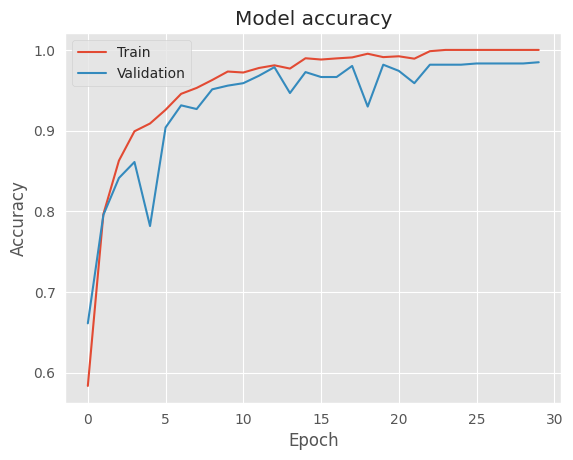

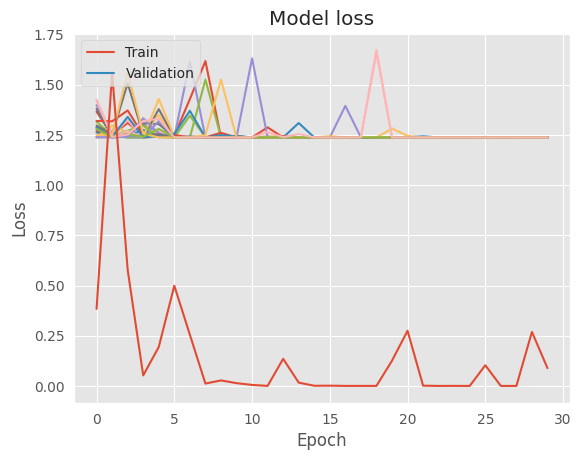

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()